<h2 style="text-align: center; font-size: 24px;">
    <span style="color: #1E90FF;">Predicting finite-volume excited state energies using ChPT and the Lüscher formula</span> 
    <br>
    <span style="color: #87CEFA;">The code</span> 
</h2>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.special import erfi
from scipy.optimize import root_scalar


In [13]:
R4PI = np.sqrt(4.0*np.pi)  # norm. factor

def summand(qSQ=1.5, nvec_arr=np.array([[0,0,0]]), alphaKSS=1.0):
    rSQ_arr = (nvec_arr**2).sum(1)
    Ds = rSQ_arr-qSQ
    return np.exp(-alphaKSS*Ds)/Ds

def T1(qSQ=1.5, C1cut=3, alphaKSS=1.0):
    rng = range(-C1cut, C1cut+1)
    mesh = np.meshgrid(*([rng]*3))
    nvec_arr = np.vstack([y.flat for y in mesh]).T
    return np.sum(summand(qSQ, nvec_arr, alphaKSS))/R4PI

def T2(qSQ=1.5, alphaKSS=1.0):
    if qSQ >= 0:
        ttmp = 2.0*(np.pi**2)*np.sqrt(qSQ)\
                * erfi(np.sqrt(alphaKSS*qSQ))\
                - 2.0*np.exp(alphaKSS*qSQ)\
                * np.sqrt(np.pi**3)/np.sqrt(alphaKSS)
    else:
        ttmp = -2.0*(np.pi**2)*np.sqrt(-qSQ)\
                * erf(np.sqrt(-alphaKSS*qSQ))\
                - 2.0*np.exp(alphaKSS*qSQ)\
                * np.sqrt(np.pi**3)/np.sqrt(alphaKSS)
    return ttmp/R4PI

In [14]:
def zeta_function(qSQ=1.5, C1cut=3, alphaKSS=1.0):
    return T1(qSQ=qSQ, C1cut=C1cut, alphaKSS=alphaKSS)\
            + T2(qSQ=qSQ, alphaKSS=alphaKSS)

Text(0, 0.5, '$\\mathcal{Z}_{0,0}(1; {q}^2)$')

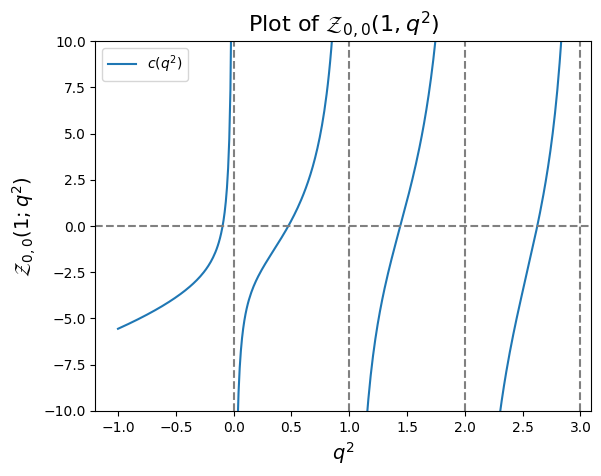

In [15]:
qSQ_set = np.linspace(-1.001, 3.001, 400)
zeta_set = []
for qSQ in qSQ_set:
    zeta_set.append(zeta_function(qSQ))
zeta_set = np.array(zeta_set)
zeta_set[np.abs(zeta_set) > 20] = np.nan
plt.plot(qSQ_set, zeta_set)
for qSQ_asymptote in range(4):
    plt.axvline(qSQ_asymptote, color='0.5', linestyle='--')
plt.legend(['$c(q^2)$'])
plt.xlabel('$q^2$')
plt.axhline(0, color='0.5', linestyle='--')
plt.ylim(-10, 10)
plt.title(r"Plot of $\mathcal{Z}_{0,0}(1, {q}^2)$", fontsize=16)
plt.xlabel(r"${q}^2$", fontsize=14)
plt.ylabel(r"$\mathcal{Z}_{0,0}(1; {q}^2)$", fontsize=14)


Text(0, 0.5, '$\\mathcal{Z}_{0,0}(1; {q}^2)$')

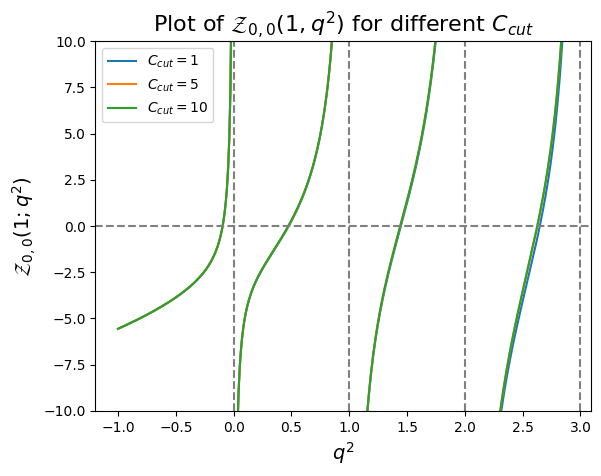

In [16]:
def plot_for_given_C1cut(ax, qSQset, C1cut):
    zeta_set = []
    for qSQ in qSQ_set:
        zeta_set.append(zeta_function(qSQ, C1cut=C1cut))
    zeta_set = np.array(zeta_set)
    zeta_set[np.abs(zeta_set) > 20] = np.nan
    ax.plot(qSQ_set, zeta_set)
ax = plt.gca()
for C1cut in [1, 5, 10]:
    plot_for_given_C1cut(ax, qSQ_set, C1cut)
for qSQ_asymptote in range(4):
    plt.axvline(qSQ_asymptote, color='0.5', linestyle='--')
plt.legend(['$C_{cut} = 1$', '$C_{cut} = 5$', '$C_{cut} = 10$'])
plt.xlabel('$q^2$')
plt.axhline(0, color='0.5', linestyle='--')
plt.ylim(-10, 10)
plt.title(r"Plot of $\mathcal{Z}_{0,0}(1, {q}^2)$ for different $C_{cut}$", fontsize=16)
plt.xlabel(r"${q}^2$", fontsize=14)
plt.ylabel(r"$\mathcal{Z}_{0,0}(1; {q}^2)$", fontsize=14)

No (significant) change for different cutoff parametres.

In [17]:
def amplitude(s, mSQ=1., fSQ=1.):  #ChPT amplitude
    return -(s - 2.*mSQ)/fSQ

def rhs(qSQ, L=4., mSQ=1., fSQ=1.):
    pre = L*np.sqrt(np.pi)/2.
    pSQ = qSQ*2.*np.pi/L
    pSQ = qSQ * (2. * np.pi / L) ** 2  # old was: pSQ = qSQ * 2. * np.pi / L
    s = 4.*(pSQ+mSQ)
    amp = amplitude(s, mSQ=mSQ, fSQ=fSQ)
    pcotd = 16.*np.pi*np.sqrt(s)/amp
    return pre*pcotd

def qc(qSQ, L=4., mSQ=1., fSQ=1., C1cut=3, alphaKSS=1.0):
    return rhs(qSQ, L=L, mSQ=mSQ, fSQ=fSQ)\
        - zeta_function(qSQ, C1cut=C1cut, alphaKSS=alphaKSS)

In [18]:
# use root scalar to find roots in qSQ from -.5 to 3.0 searching all intervals of width 0.1
from scipy.optimize import root_scalar
roots = []
for qSQ in np.arange(-0.5, 3.0, 0.01):
    try:
        res = root_scalar(qc, args=(4., 1., 1., 3, 1.0), bracket=[qSQ, qSQ+0.1])
        if res.converged:
            if np.abs(qc(res.root, 4., 1., 1., 3, 1.0)) < 1e-6:
                roots.append(res.root)
    except ValueError:
        pass
roots = np.array(roots)
print(roots)

C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp


[1.61545776e-03 1.03079103e+00 1.03079103e+00 1.03079103e+00
 1.03079103e+00 2.08836519e+00 2.08836519e+00 2.08836519e+00
 2.08836519e+00 2.08836519e+00 2.08836519e+00 2.08836519e+00
 2.08836519e+00 2.08836519e+00]


<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\578154254.py:19: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("L * $m_\pi$")
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\578154254.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("Energy Levels / $m_\pi$")


Text(0, 0.5, 'Energy Levels / $m_\\pi$')

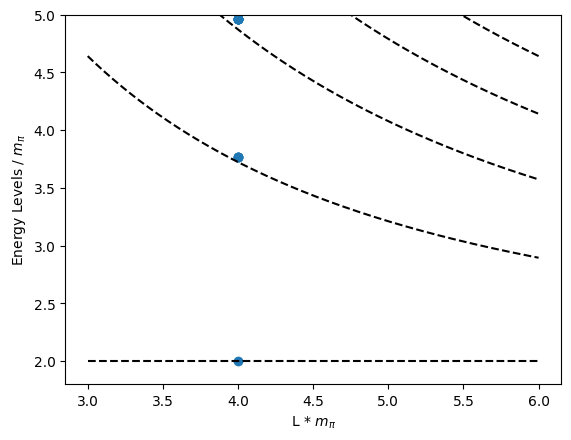

In [19]:
E_vals = []
L = 4.
mSQ = 1.
for root in roots:
    pSQ = root*(2.*np.pi/L)**2
    s = 4.*(pSQ+mSQ)
    E_vals.append(np.sqrt(s))
E_vals = np.array(E_vals)

# plot the energy levels vs L where L=4 for all
plt.plot([4.]*len(E_vals), E_vals, 'o')

# plot the nonint spectrum for L from 3 to 6
L_set = np.linspace(3, 6, 400)
for nSQ in range(6):
    E_vals = 2*np.sqrt(nSQ*(2.*np.pi/L_set)**2 + mSQ)
    plt.plot(L_set, E_vals, 'k--')
plt.ylim(1.8, 5)
plt.xlabel("L * $m_\pi$")
plt.ylabel("Energy Levels / $m_\pi$")

This plots the analytical curves for the excited states and includes only one numerically computed point. We will now produce the same plot but with more numerically computed solutions.

### $F_\pi=1$ We wil try different F_\pi later

<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\464982731.py:50: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("L * $m_\pi$")
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\464982731.py:51: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("Energy / $m_\pi$")
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp



 *** Energy Levels for Different L Values *** 
        L    Energy
0    3.00  2.009551
1    3.00  4.744009
2    3.00  6.470070
3    3.04  2.009172
4    3.04  4.690130
..    ...       ...
229  6.04  2.896337
230  6.04  3.581053
231  6.08  2.001124
232  6.08  2.886258
233  6.08  3.564559

[234 rows x 2 columns]


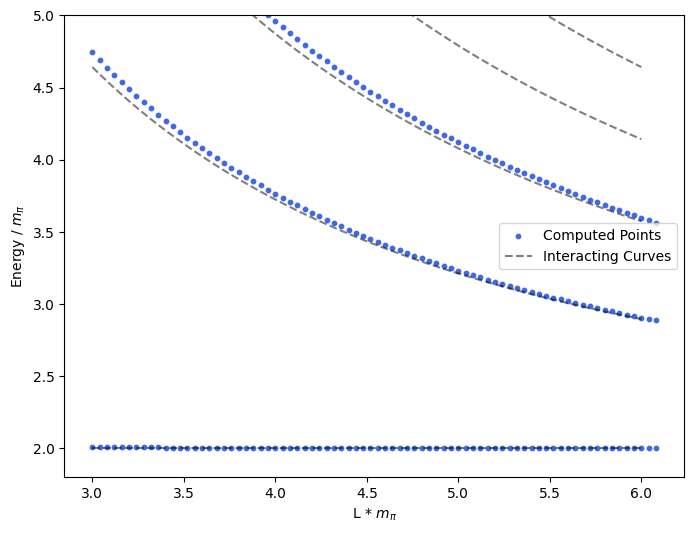

In [60]:
L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
mSQ = 1.0
fSQ = 1.0

Lvalues = []
Evalues = []

for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    if not any(np.isclose(res.root, roots, atol=1e-9)):  # Remove duplicates
                        roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    E_vals = []
    for root in roots:
        pSQ = root * (2. * np.pi / L) ** 2
        s = 4. * (pSQ + mSQ)
        E_vals.append(np.sqrt(s))

    # Store results for each L
    for E in E_vals:
        Lvalues.append(L)
        Evalues.append(E)

pion_mass = np.sqrt(mSQ)
dimensionless_L = np.array(Lvalues) * pion_mass
dimensionless_E = np.array(Evalues) / pion_mass

# DataFrame
energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})

print("\n *** Energy Levels for Different L Values *** ")
print(energy_df)


plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
L_set = np.linspace(3, 6, 400)
for nSQ in range(6):
    E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
    plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Interacting Curves" if nSQ == 0 else "")
plt.xlabel("L * $m_\pi$")
plt.ylabel("Energy / $m_\pi$")
plt.ylim(1.8, 5)
plt.legend()


In [61]:
"""L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
mSQ = 1.0
fSQ = 1.0

Lvalues = []
Evalues = []

for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    if not any(np.isclose(res.root, roots, atol=1e-9)):

                        roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    E_vals = []
    for root in roots:
        pSQ = root * (2. * np.pi / L) ** 2
        s = 4. * (pSQ + mSQ)
        E_vals.append(np.sqrt(s))

    # Store results for each L
    for E in E_vals:
        Lvalues.append(L)
        Evalues.append(E)

pion_mass = np.sqrt(mSQ)
dimensionless_L = np.array(Lvalues) * pion_mass
dimensionless_E = np.array(Evalues) / pion_mass

# DataFrame
energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})

print("\n *** Energy Levels for Different L Values *** ")
print(energy_df)


plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
L_set = np.linspace(3, 6, 400)
for nSQ in range(6):
    E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
    plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Interacting Curves" if nSQ == 0 else "")
plt.xlabel("L * $m_\pi$")
plt.ylabel("Energy / $m_\pi$")
plt.ylim(1.8, 5)
plt.legend()"
"""


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\513450598.py:1: SyntaxWarning: invalid escape sequence '\p'
  """L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04


'L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04\nmSQ = 1.0\nfSQ = 1.0\n\nLvalues = []\nEvalues = []\n\nfor L in L_values:\n    roots = []\n    for qSQ in np.arange(-0.5, 3.0, 0.01):\n        try:\n            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])\n            if res.converged:\n                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:\n                    if not any(np.isclose(res.root, roots, atol=1e-9)):\n\n                        roots.append(res.root)\n        except ValueError:\n            pass\n\n    roots = np.array(roots)\n\n    E_vals = []\n    for root in roots:\n        pSQ = root * (2. * np.pi / L) ** 2\n        s = 4. * (pSQ + mSQ)\n        E_vals.append(np.sqrt(s))\n\n    # Store results for each L\n    for E in E_vals:\n        Lvalues.append(L)\n        Evalues.append(E)\n\npion_mass = np.sqrt(mSQ)\ndimensionless_L = np.array(Lvalues) * pion_mass\ndimensionless_E = np.array(Evalues) / pion_mass\n\

In [62]:
analytical_energies = []

for i, L in enumerate(dimensionless_L):  # Iterate over each L value
    closest_nint_E = None
    min_diff = float('inf')
    
    for nSQ in range(6):
        E_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L) ** 2 + mSQ)

        diff = abs(E_nonint - dimensionless_E[i])
        
        if diff < min_diff:
            closest_nint_E = E_nonint
            min_diff = diff
    
    analytical_energies.append(closest_nint_E)  # store

analytical_energies = np.array(analytical_energies)

# print(analytical_energies)
L_values = np.arange(3.0, 6.1, 0.04)

differences = dimensionless_E - analytical_energies


In [63]:
dimensionless_E = np.nan_to_num(dimensionless_E, nan=0.0)
analytical_energies = np.nan_to_num(analytical_energies, nan=0.0)

differences = dimensionless_E - analytical_energies

diff_df = pd.DataFrame({"Dimensionless L": dimensionless_L, "Difference": differences})

print(diff_df)

     Dimensionless L  Difference
0               3.00    0.009551
1               3.00    0.102246
2               3.00    0.217716
3               3.04    0.009172
4               3.04    0.098042
..               ...         ...
229             6.04    0.010409
230             6.04    0.023362
231             6.08    0.001124
232             6.08    0.010182
233             6.08    0.022860

[234 rows x 2 columns]


In [64]:
E_level_1 = [dimensionless_E[i] if i %3 == 0 else None for i in range(len(dimensionless_E))]
E_level_2 = [dimensionless_E[i] if i %3 == 1 else None for i in range(len(dimensionless_E))]
E_level_3 = [dimensionless_E[i] if i %3 == 2 else None for i in range(len(dimensionless_E))]
E_level_4 = [dimensionless_E[i] if i %3 == 3 else None for i in range(len(dimensionless_E))]

#print("E_level_1:", E_level_1)
differences_1 = [differences[i] if i %3 == 0 else None for i in range(len(differences))]
L_1 = [dimensionless_L[i] if i %3 == 0 else None for i in range(len(dimensionless_L))]
differences_2 = [differences[i] if i %3 == 1 else None for i in range(len(differences))]
L_2 = [dimensionless_L[i] if i %3 == 1 else None for i in range(len(dimensionless_L))]
differences_3 = [differences[i] if i %3 == 2 else None for i in range(len(differences))]
L_3 = [dimensionless_L[i] if i %3 == 2 else None for i in range(len(dimensionless_L))]
differences_4 = [differences[i] if i %3 == 3 else None for i in range(len(differences))]
L_4 = [dimensionless_L[i] if i %3 == 3 else None for i in range(len(dimensionless_L))]
print(len(differences_1), len(L_1))
print(len(differences_2), len(L_2))
print(len(differences_3), len(L_3))

234 234
234 234
234 234


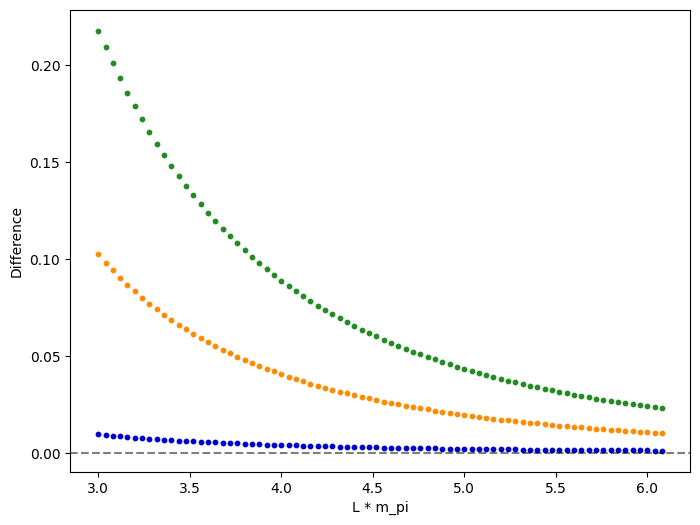

In [40]:
#diff_df = pd.DataFrame({"Energy": dimensionless_L, "Difference": differences})
#print("\n=== Energy Differences ===")
#print(diff_df)

# dimensionless energy vs differences
plt.figure(figsize=(8, 6))
plt.scatter(L_1,differences_1 , color='mediumblue', s=10)
plt.scatter(L_2,differences_2 , color='darkorange', s=10)
plt.scatter(L_3,differences_3 , color='forestgreen', s=10)
#plt.scatter(L_4,differences_4 , color='firebrick', s=10)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Difference")
plt.xlabel("L * m_pi")
plt.show()

In [ ]:
for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    if not any(np.isclose(res.root, roots, atol=1e-3)):  # Remove duplicates
                        roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    # Print unique roots for each L
    print(f"L = {L:.2f}, Unique roots: {roots}")


/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_24895/4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp


L = 3.00, Unique roots: [0.00218254 1.05469379 2.15786427]
L = 3.04, Unique roots: [2.15204603e-03 1.05325898e+00 2.15378070e+00]
L = 3.08, Unique roots: [2.12242716e-03 1.05187997e+00 2.14984182e+00]
L = 3.12, Unique roots: [2.09364072e-03 1.05055401e+00 2.14604196e+00]
L = 3.16, Unique roots: [2.06565076e-03 1.04927847e+00 2.14237565e+00]
L = 3.20, Unique roots: [2.03842346e-03 1.04805090e+00 2.13883755e+00]
L = 3.24, Unique roots: [2.01192694e-03 1.04686898e+00 2.13542254e+00]
L = 3.28, Unique roots: [1.98613114e-03 1.04573053e+00 2.13212564e+00]
L = 3.32, Unique roots: [1.96100769e-03 1.04463348e+00 2.12894210e+00]
L = 3.36, Unique roots: [1.93652978e-03 1.04357590e+00 2.12586731e+00]
L = 3.40, Unique roots: [1.91267204e-03 1.04255595e+00 2.12289687e+00]
L = 3.44, Unique roots: [1.88941047e-03 1.04157190e+00 2.12002653e+00]
L = 3.48, Unique roots: [1.86672232e-03 1.04062212e+00 2.11725225e+00]
L = 3.52, Unique roots: [1.84458602e-03 1.03970507e+00 2.11457012e+00]
L = 3.56, Unique r


=== Energy Differences ===
       Energy  Difference
0    2.009551    0.009551
1    4.744009    0.102246
2    6.470070    0.217716
3    2.009172    0.009172
4    4.690130    0.098042
..        ...         ...
229  2.896337    0.010409
230  3.581053    0.023362
231  2.001124    0.001124
232  2.886258    0.010182
233  3.564559    0.022860

[234 rows x 2 columns]


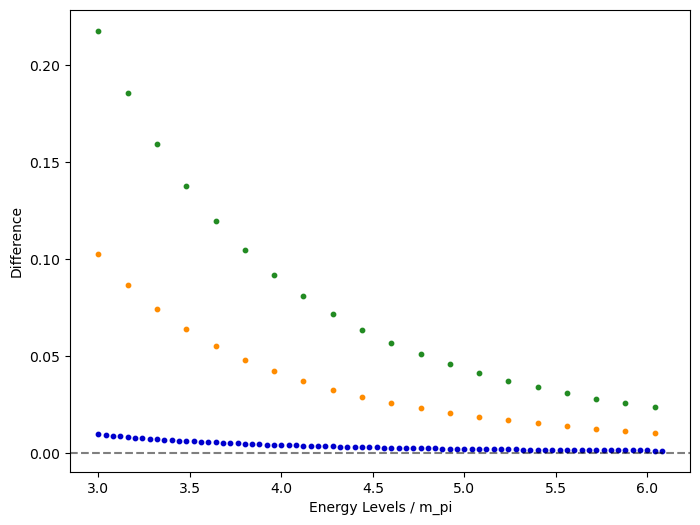

In [ ]:
diff_df = pd.DataFrame({"Energy": dimensionless_E, "Difference": differences})
print("\n=== Energy Differences ===")
print(diff_df)

# dimensionless energy vs differences
plt.figure(figsize=(8, 6))
plt.scatter(L_1,differences_1 , color='mediumblue', s=10)
plt.scatter(L_2,differences_2 , color='darkorange', s=10)
plt.scatter(L_3,differences_3 , color='forestgreen', s=10)
plt.scatter(L_4,differences_4 , color='firebrick', s=10)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Difference")
plt.xlabel("Energy Levels / m_pi")
# plt.title("$\delta$")
plt.show()


=== Energy Differences ===
       Energy  Difference
0    2.009551    0.009551
1    4.744009    0.102246
2    6.470070    0.217716
3    2.009172    0.009172
4    4.690130    0.098042
..        ...         ...
229  2.896337    0.010409
230  3.581053    0.023362
231  2.001124    0.001124
232  2.886258    0.010182
233  3.564559    0.022860

[234 rows x 2 columns]


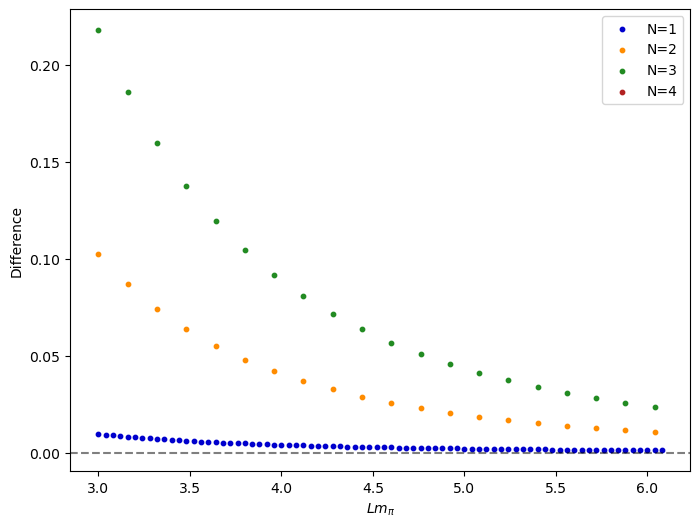

In [ ]:
analytical_energies = []

for i, L in enumerate(dimensionless_L):  # Iterate over each L value
    closest_nint_E = None
    min_diff = float('inf')
    
    for nSQ in range(6):
        E_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L) ** 2 + mSQ)

        diff = abs(E_nonint - dimensionless_E[i])
        
        if diff < min_diff:
            closest_nint_E = E_nonint
            min_diff = diff
    
    analytical_energies.append(closest_nint_E)  # store

analytical_energies = np.array(analytical_energies)

# print(analytical_energies)

differences = dimensionless_E - analytical_energies


diff_df = pd.DataFrame({"Energy": dimensionless_E, "Difference": differences})
print("\n=== Energy Differences ===")
print(diff_df)

# dimensionless energy vs differences
plt.figure(figsize=(8, 6))
plt.scatter(L_1,differences_1 , color='mediumblue', s=10, label="N=1")
plt.scatter(L_2,differences_2 , color='darkorange', s=10, label="N=2")
plt.scatter(L_3,differences_3 , color='forestgreen', s=10, label="N=3")
plt.scatter(L_4,differences_4 , color='firebrick', s=10, label="N=4")
plt.legend()
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Difference")
plt.xlabel("$Lm_\pi$")
# plt.title("$\delta$")
plt.show()


     Dimensionless L  Difference
0               3.00    0.009551
1               3.00    0.102246
2               3.00    0.217716
3               3.04    0.009172
4               3.04    0.098042
..               ...         ...
229             6.04    0.010409
230             6.04    0.023362
231             6.08    0.001124
232             6.08    0.010182
233             6.08    0.022860

[234 rows x 2 columns]


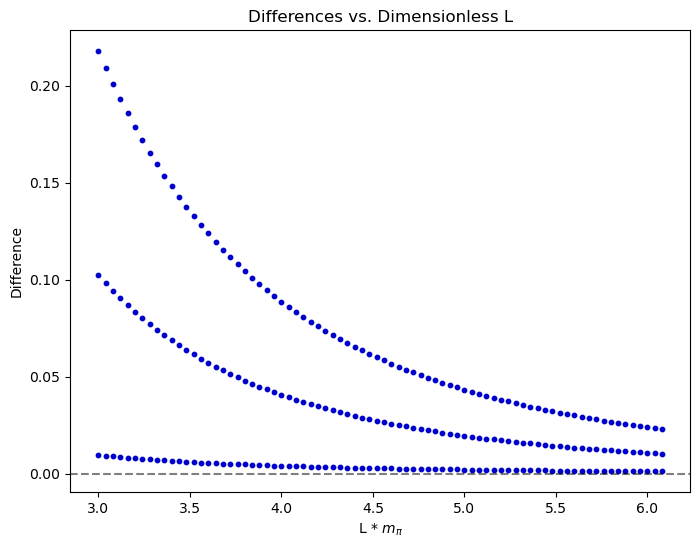

     Dimensionless L  Difference
0               3.00    0.009551
1               3.00    0.102246
2               3.00    0.217716
3               3.04    0.009172
4               3.04    0.098042
..               ...         ...
229             6.04    0.010409
230             6.04    0.023362
231             6.08    0.001124
232             6.08    0.010182
233             6.08    0.022860

[234 rows x 2 columns]


In [ ]:
# Ensure all energy values are valid
dimensionless_E = np.nan_to_num(dimensionless_E, nan=0.0)
analytical_energies = np.nan_to_num(analytical_energies, nan=0.0)

# Compute differences
differences = dimensionless_E - analytical_energies

# Create DataFrame
diff_df = pd.DataFrame({"Dimensionless L": dimensionless_L, "Difference": differences})

# Display DataFrame
print(diff_df)

# Plot differences vs. dimensionless_L
plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, differences, color='mediumblue', s=10)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.ylabel("Difference")
plt.xlabel("L * $m_\pi$")
plt.title("Differences vs. Dimensionless L")
plt.show()

print(diff_df)


Close agreement between the interacting courves given by and the computed points. The difference between them can provide us insight on computing the phase shift $\delta$. By inspecting the interacting curve at $E/m_\pi = 2$ we can see that there is an attractive interaction at $L * m_\pi < 4$.

### $F_\pi=0.8$ 

In [ ]:
L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
mSQ = 1.0
fSQ = 0.8

Lvalues = []
Evalues = []

for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    E_vals = []
    for root in roots:
        pSQ = root * (2. * np.pi / L) ** 2
        s = 4. * (pSQ + mSQ)
        E_vals.append(np.sqrt(s))

    # Store results for each L
    for E in E_vals:
        Lvalues.append(L)
        Evalues.append(E)

pion_mass = np.sqrt(mSQ)
dimensionless_L = np.array(Lvalues) * pion_mass
dimensionless_E = np.array(Evalues) / pion_mass

# DataFrame
energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})

print("\n *** Energy Levels for Different L Values *** ")
print(energy_df)


plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
L_set = np.linspace(3, 6, 400)
for nSQ in range(6):
    E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
    plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Interacting Curves" if nSQ == 0 else "")
plt.xlabel("L * $m_\pi$")
plt.ylabel("Energy / $m_\pi$")
plt.ylim(1.8, 5)
plt.legend()



### $F_\pi=1.2$ 

<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:50: SyntaxWarning: invalid escape sequence '\p'
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\267691698.py:49: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("L * $m_\pi$")
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\267691698.py:50: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("Energy / $m_\pi$")
C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp



 *** Energy Levels for Different L Values *** 
        L    Energy
0    3.00  2.007917
1    3.00  4.726915
2    3.00  4.726915
3    3.00  4.726915
4    3.00  4.726915
..    ...       ...
810  6.08  2.884554
811  6.08  3.560698
812  6.08  3.560698
813  6.08  3.560698
814  6.08  3.560698

[815 rows x 2 columns]


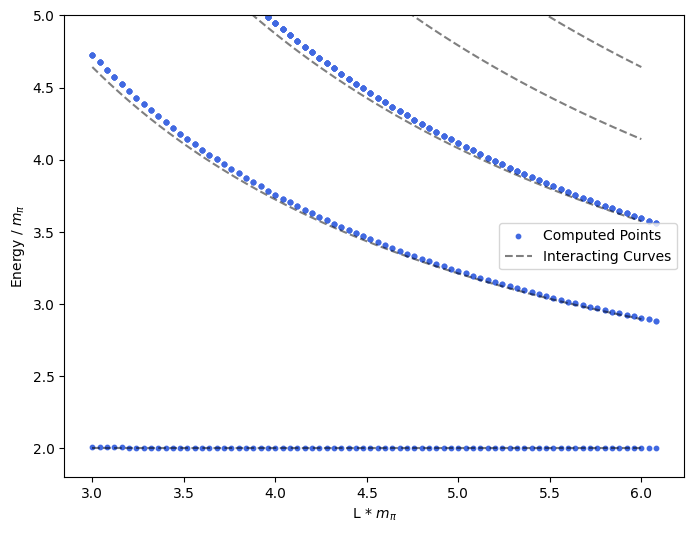

In [59]:
L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
mSQ = 1.0
fSQ = 1.2

Lvalues = []
Evalues = []

for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    E_vals = []
    for root in roots:
        pSQ = root * (2. * np.pi / L) ** 2
        s = 4. * (pSQ + mSQ)
        E_vals.append(np.sqrt(s))

    # Store results for each L
    for E in E_vals:
        Lvalues.append(L)
        Evalues.append(E)

pion_mass = np.sqrt(mSQ)
dimensionless_L = np.array(Lvalues) * pion_mass
dimensionless_E = np.array(Evalues) / pion_mass

# DataFrame
energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})

print("\n *** Energy Levels for Different L Values *** ")
print(energy_df)


plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
L_set = np.linspace(3, 6, 400)
for nSQ in range(6):
    E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
    plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Interacting Curves" if nSQ == 0 else "")
plt.xlabel("L * $m_\pi$")
plt.ylabel("Energy / $m_\pi$")
plt.ylim(1.8, 5)
plt.legend()



### $F_\pi=0.1$ 

In [ ]:
L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
mSQ = 1.0
fSQ = 0.1

Lvalues = []
Evalues = []

for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    E_vals = []
    for root in roots:
        pSQ = root * (2. * np.pi / L) ** 2
        s = 4. * (pSQ + mSQ)
        E_vals.append(np.sqrt(s))

    # Store results for each L
    for E in E_vals:
        Lvalues.append(L)
        Evalues.append(E)

pion_mass = np.sqrt(mSQ)
dimensionless_L = np.array(Lvalues) * pion_mass
dimensionless_E = np.array(Evalues) / pion_mass

# DataFrame
energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})

print("\n *** Energy Levels for Different L Values *** ")
print(energy_df)


plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
L_set = np.linspace(3, 6, 400)
for nSQ in range(6):
    E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
    plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Interacting Curves" if nSQ == 0 else "")
plt.xlabel("L * $m_\pi$")
plt.ylabel("Energy / $m_\pi$")
plt.ylim(1.8, 5)
plt.legend()



### $F_\pi=4$ 

In [ ]:
L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
mSQ = 1.0
fSQ = 4

Lvalues = []
Evalues = []

for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    E_vals = []
    for root in roots:
        pSQ = root * (2. * np.pi / L) ** 2
        s = 4. * (pSQ + mSQ)
        E_vals.append(np.sqrt(s))

    # Store results for each L
    for E in E_vals:
        Lvalues.append(L)
        Evalues.append(E)

pion_mass = np.sqrt(mSQ)
dimensionless_L = np.array(Lvalues) * pion_mass
dimensionless_E = np.array(Evalues) / pion_mass

# DataFrame
energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})

print("\n *** Energy Levels for Different L Values *** ")
print(energy_df)


plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
L_set = np.linspace(3, 6, 400)
for nSQ in range(6):
    E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
    plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Interacting Curves" if nSQ == 0 else "")
plt.xlabel("L * $m_\pi$")
plt.ylabel("Energy / $m_\pi$")
plt.ylim(1.8, 5)
plt.legend()



In [ ]:
def main():
    sqrt_s = np.linspace(0,10,10000)
    m_pi = 0.5
    f_pi = 0.3
    phase = phase_shift(sqrt_s,m_pi,f_pi)
    plt.plot(sqrt_s,phase)
    plt.xlabel("s")
    plt.ylabel("$\delta$")
    plt.title(r"Phase Shift $\delta(s)$")
    plt.show()
    pass
def phase_shift(sqrt_s,m_pi,f_pi):
    P = np.sqrt(sqrt_s**2/4-m_pi**2)
    amplitude = (sqrt_s**2 - m_pi**2)/f_pi**2
    prefactor = 1/(16*np.pi*sqrt_s)
    factor =  prefactor*P*amplitude
    return np.arctan(factor)
main()

[0]
[0]


C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp


[ 2.01914272  8.83205971 12.46733097 ...  2.00224129  4.61638932
  6.23005917]


Text(0, 0.5, 'Difference')

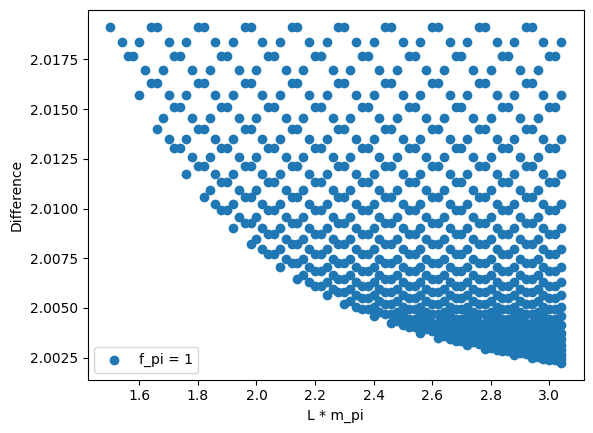

In [58]:
fpis = [1]
m_pi = 0.5
Lss = [0 for i in range(len(fpis))]
diffs = [0 for i in range(len(fpis))]
Ess = [0 for i in range(len(fpis))]
print(diffs)
print(Lss)
for j,f_pi in enumerate(fpis):
    Lvalues = []
    Evalues = []
    L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
    fSQ = f_pi**2
    mSQ = m_pi**2
    E_vals = []

    for L in L_values:
        roots = []
        for qSQ in np.arange(-0.5, 3.0, 0.01):
            try:
                res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
                if res.converged:
                    if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                        if not any(np.isclose(res.root, roots, atol=1e-3)):  # Remove duplicates
                            roots.append(res.root)
            except ValueError:
                pass
        for root in roots:
            pSQ = root * (2. * np.pi / L) ** 2
            s = 4. * (pSQ + mSQ)
            E_vals.append(np.sqrt(s))

    # Store results for each L
        for E in E_vals:
            Lvalues.append(L)
            Evalues.append(E)



    pion_mass = np.sqrt(mSQ)
    dimensionless_L = np.array(Lvalues) * pion_mass
    dimensionless_E = np.array(Evalues) / pion_mass
    print(dimensionless_E)
    level_0 = [dimensionless_E[i] if i % 3 == 0 else None for i in range(len(dimensionless_E))]
    level_0_L = [dimensionless_L[i] if i % 3 == 0 else None for i in range(len(dimensionless_L))]
    analytical_energies = []
    for i, L in enumerate(dimensionless_L):  # Iterate over each L value
        closest_nint_E = None
        min_diff = float('inf')
    
        for nSQ in range(6):
            E_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L) ** 2 + mSQ)

            diff = abs(E_nonint - dimensionless_E[i])
            
            if diff < min_diff:
                closest_nint_E = E_nonint
                min_diff = diff
    
        analytical_energies.append(closest_nint_E)
    n_levels = 4
    level_0_analytical = [analytical_energies[i] if i % n_levels == 0 else None for i in range(len(analytical_energies))]
    differences = dimensionless_E - analytical_energies
    differences_0 = [differences[i] if i % n_levels == 0 else None for i in range(len(differences))]
    L_difference_0 = [dimensionless_L[i] if i % n_levels == 0 else None for i in range(len(dimensionless_L))]
    diffs[j] = differences_0
    Lss[j] = L_difference_0
    Ess[j] = level_0
for i in range(len(fpis)):
    #plt.scatter(Lss[i],diffs[i],label=f"f_pi = {fpis[i]}")
    plt.scatter(Lss[i],Ess[i],label=f"f_pi = {fpis[i]}")
plt.legend()
plt.xlabel("L * m_pi")
plt.ylabel("Difference")

    

In [50]:
print(diffs)

[[np.float64(0.1623133003396895), None, None, np.float64(-0.8367771554760708), None, None, np.float64(-1.5182544247937901), None, None, np.float64(-2.5696153096072933), None, None, np.float64(0.1623133003396895), None, None, np.float64(-0.4607993150062093), None, None, np.float64(-1.497259100611517), None, None, np.float64(-2.5365987323195833), None, None, np.float64(0.1623133003396895), None, None, np.float64(-0.2800582779115537), None, None, np.float64(-1.3498704583607903), None, None, np.float64(-2.4327704003558432), None, None, np.float64(0.09769982496342244), None, None, np.float64(-0.7971872104475679), None, None, np.float64(-1.0759406474292117), None, None, np.float64(-2.258025765472027), None, None, np.float64(0.1215685930273307), None, None, np.float64(-0.4531779676062673), None, None, np.float64(-1.4566237680146052), None, None, np.float64(-2.473202388593), None, None, np.float64(0.1623133003396895), None, None, np.float64(0.06783402652210313), None, None, np.float64(-1.06618

C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp



 *** Energy Levels for Different L Values *** 
        L    Energy
0    3.00  2.009551
1    3.00  4.744009
2    3.00  6.470070
3    3.04  2.009172
4    3.04  4.690130
..    ...       ...
229  6.04  2.896337
230  6.04  3.581053
231  6.08  2.001124
232  6.08  2.886258
233  6.08  3.564559

[234 rows x 2 columns]
     Dimensionless L  Difference
0               3.00    0.009551
1               3.00    0.102246
2               3.00    0.217716
3               3.04    0.009172
4               3.04    0.098042
..               ...         ...
229             6.04    0.010409
230             6.04    0.023362
231             6.08    0.001124
232             6.08    0.010182
233             6.08    0.022860

[234 rows x 2 columns]
234 234
234 234
234 234


C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp



 *** Energy Levels for Different L Values *** 
        L    Energy
0    3.00  2.019729
1    3.00  4.843700
2    3.00  6.654350
3    3.04  2.018932
4    3.04  4.785996
..    ...       ...
229  6.04  2.906842
230  6.04  3.604998
231  6.08  2.002273
232  6.08  2.896533
233  6.08  3.587989

[234 rows x 2 columns]
     Dimensionless L  Difference
0               3.00    0.019729
1               3.00    0.201937
2               3.00    0.401997
3               3.04    0.018932
4               3.04    0.193909
..               ...         ...
229             6.04    0.020913
230             6.04    0.047307
231             6.08    0.002273
232             6.08    0.020456
233             6.08    0.046290

[234 rows x 2 columns]
234 234
234 234
234 234


C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp



 *** Energy Levels for Different L Values *** 
        L    Energy
0    3.00  2.004701
1    3.00  4.692680
2    3.00  6.361004
3    3.04  2.004516
4    3.04  4.640903
..    ...       ...
229  6.04  2.891118
230  6.04  3.569272
231  6.08  2.000559
232  6.08  2.881153
233  6.08  3.553032

[234 rows x 2 columns]
     Dimensionless L  Difference
0               3.00    0.004701
1               3.00    0.050917
2               3.00    0.108651
3               3.04    0.004516
4               3.04    0.048816
..               ...         ...
229             6.04    0.005189
230             6.04    0.011580
231             6.08    0.000559
232             6.08    0.005076
233             6.08    0.011333

[234 rows x 2 columns]
234 234
234 234
234 234


C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp



 *** Energy Levels for Different L Values *** 
        L    Energy
0    3.00  2.003118
1    3.00  4.675614
2    3.00  6.324270
3    3.04  2.002996
4    3.04  4.624542
..    ...       ...
229  6.04  2.889385
230  6.04  3.565387
231  6.08  2.000372
232  6.08  2.879457
233  6.08  3.549230

[234 rows x 2 columns]
     Dimensionless L  Difference
0               3.00    0.003118
1               3.00    0.033851
2               3.00    0.071916
3               3.04    0.002996
4               3.04    0.032455
..               ...         ...
229             6.04    0.003456
230             6.04    0.007695
231             6.08    0.000372
232             6.08    0.003381
233             6.08    0.007531

[234 rows x 2 columns]
234 234
234 234
234 234


C:\Users\pmora\AppData\Local\Temp\ipykernel_39420\4226046690.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp



 *** Energy Levels for Different L Values *** 
        L    Energy
0    3.00  2.002333
1    3.00  4.667110
2    3.00  6.306037
3    3.04  2.002241
4    3.04  4.616389
..    ...       ...
227  6.00  3.579819
228  6.04  2.888519
229  6.04  3.563453
230  6.08  2.878611
231  6.08  3.547338

[232 rows x 2 columns]
     Dimensionless L  Difference
0               3.00    0.002333
1               3.00    0.025347
2               3.00    0.053683
3               3.04    0.002241
4               3.04    0.024302
..               ...         ...
227             6.00    0.005888
228             6.04    0.002591
229             6.04    0.005762
230             6.08    0.002534
231             6.08    0.005639

[232 rows x 2 columns]
232 232
232 232
232 232


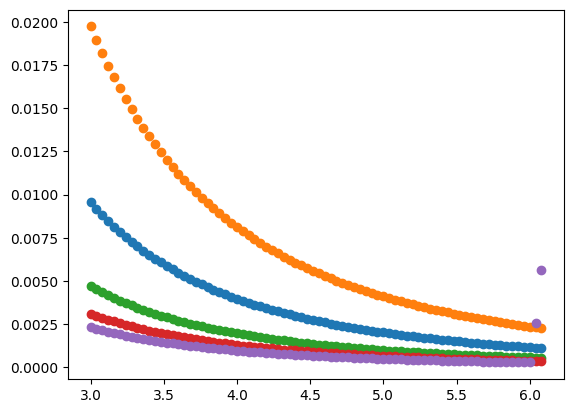

In [83]:
fpis = [1,0.5,2,3,4]
level_0_diff = [0 for i in range(len(fpis))]
Lss = [0 for i in range(len(fpis))]

for j,f_pi in enumerate(fpis):
    L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
    mSQ = 1.0
    fSQ = fpis[j]

    Lvalues = []
    Evalues = []

    for L in L_values:
        roots = []
        for qSQ in np.arange(-0.5, 3.0, 0.01):
            try:
                res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
                if res.converged:
                    if np.abs(qc(res.root, L, mSQ, fSQ,3, 1.0)) < 1e-6:
                        if not any(np.isclose(res.root, roots, atol=1e-9)):  # Remove duplicates
                            roots.append(res.root)
            except ValueError:
                pass

        roots = np.array(roots)
        
        E_vals = []
        for root in roots:
            pSQ = root * (2. * np.pi / L) ** 2
            s = 4. * (pSQ + mSQ)
            E_vals.append(np.sqrt(s))

        # Store results for each L
        for E in E_vals:
            Lvalues.append(L)
            Evalues.append(E)
    pion_mass = np.sqrt(mSQ)
    dimensionless_L = np.array(Lvalues) * pion_mass
    dimensionless_E = np.array(Evalues) / pion_mass

    # DataFrame
    energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})

    print("\n *** Energy Levels for Different L Values *** ")
    print(energy_df)


    #plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
    L_set = np.linspace(3, 6, 400)
    for nSQ in range(6):
        E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
        #plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Interacting Curves" if nSQ == 0 else "")
    
    analytical_energies = []

    for i, L in enumerate(dimensionless_L):  # Iterate over each L value
        closest_nint_E = None
        min_diff = float('inf')
        
        for nSQ in range(6):
            E_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L) ** 2 + mSQ)

            diff = abs(E_nonint - dimensionless_E[i])
            
            if diff < min_diff:
                closest_nint_E = E_nonint
                min_diff = diff
        
        analytical_energies.append(closest_nint_E)  # store

    analytical_energies = np.array(analytical_energies)

    # print(analytical_energies)
    L_values = np.arange(3.0, 6.1, 0.04)

    differences = dimensionless_E - analytical_energies
    dimensionless_E = np.nan_to_num(dimensionless_E, nan=0.0)
    analytical_energies = np.nan_to_num(analytical_energies, nan=0.0)

    differences = dimensionless_E - analytical_energies

    diff_df = pd.DataFrame({"Dimensionless L": dimensionless_L, "Difference": differences})

    print(diff_df)

    E_level_1 = [dimensionless_E[i] if i %3 == 0 else None for i in range(len(dimensionless_E))]
    E_level_2 = [dimensionless_E[i] if i %3 == 1 else None for i in range(len(dimensionless_E))]
    E_level_3 = [dimensionless_E[i] if i %3 == 2 else None for i in range(len(dimensionless_E))]
    E_level_4 = [dimensionless_E[i] if i %3 == 3 else None for i in range(len(dimensionless_E))]

    #print("E_level_1:", E_level_1)
    differences_1 = [differences[i] if i %3 == 0 else None for i in range(len(differences))]
    L_1 = [dimensionless_L[i] if i %3 == 0 else None for i in range(len(dimensionless_L))]
    differences_2 = [differences[i] if i %3 == 1 else None for i in range(len(differences))]
    L_2 = [dimensionless_L[i] if i %3 == 1 else None for i in range(len(dimensionless_L))]
    differences_3 = [differences[i] if i %3 == 2 else None for i in range(len(differences))]
    L_3 = [dimensionless_L[i] if i %3 == 2 else None for i in range(len(dimensionless_L))]
    differences_4 = [differences[i] if i %3 == 3 else None for i in range(len(differences))]
    L_4 = [dimensionless_L[i] if i %3 == 3 else None for i in range(len(dimensionless_L))]
    Lss[j] = L_1.copy()
    level_0_diff[j] = differences_1.copy()
    print(len(differences_1), len(L_1))
    print(len(differences_2), len(L_2))
    print(len(differences_3), len(L_3))

for i in range(len(fpis)):
    plt.scatter(Lss[i],level_0_diff[i],label=f"f_pi = {fpis[i]}")

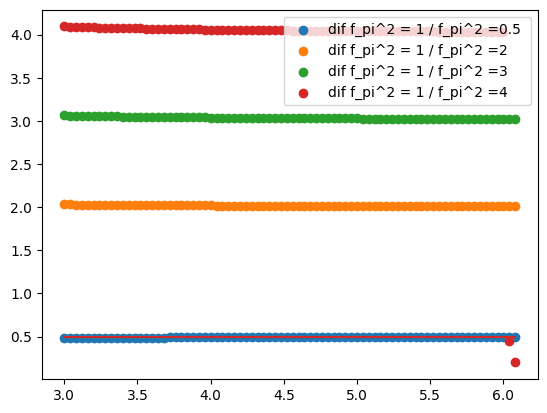

In [85]:
for j in range(1,len(fpis)):
    level_0_1 = np.array([item for item in level_0_diff[0] if item is not None])
    level_0_2 = np.array([item for item in level_0_diff[j] if item is not None])
    Ls = np.array([item for item in Lss[0] if item is not None])
                    
    div = level_0_1 / level_0_2
    plt.scatter(Ls,div,label=f"dif f_pi^2 = {fpis[0]} / f_pi^2 ={fpis[j]} ")
    y = [fpis[1]/fpis[0] for i in range(len(Ls))]
    plt.plot(Ls,y)
    plt.legend()


In [77]:
print(level_0_diff[0])

[np.float64(0.009550867432625676), None, None, np.float64(0.009172113401561877), None, None, np.float64(0.008813233297333412), None, None, np.float64(0.008472932397598942), None, None, np.float64(0.008150016584532072), None, None, np.float64(0.007843383274924065), None, None, np.float64(0.007552013279948699), None, None, np.float64(0.007274963487928332), None, None, np.float64(0.007011360276959255), None, None, np.float64(0.006760393575924617), None, None, np.float64(0.006521311502457827), None, None, np.float64(0.006293415515138179), None, None, np.float64(0.006076056024717946), None, None, np.float64(0.005868628415752308), None, None, np.float64(0.005670569435674455), None, None, np.float64(0.005481353912633047), None, None, np.float64(0.005300491774627769), None, None, np.float64(0.005127525317435211), None, None, np.float64(0.004962026740808589), None, None, np.float64(0.0048035958733412265), None, None, np.float64(0.00465185810608304), None, None, np.float64(0.004506462499215047),